Интернет-магазин запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import notebook

import re

import torch

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

from transformers import pipeline

from transformers import DistilBertTokenizer, DistilBertModel, AutoTokenizer, AutoModelForSequenceClassification

import datasets
from datasets import load_metric
from torch.utils.data import DataLoader
from torch.optim import AdamW
from transformers import get_scheduler
from tqdm.auto import tqdm

import random

sns.set_theme(style="darkgrid")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

In [4]:
torch.cuda.current_device()

0

In [5]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.use_deterministic_algorithms(True)

## Подготовка

In [6]:
df = pd.read_csv('/content/new_df', index_col=[0])

In [7]:
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [8]:
df['text'] = df['text'].apply(lambda x: re.sub('\\n', ' ', x).lower())

In [9]:
df.shape

(159292, 2)

In [10]:
df

,text,toxic
0,explanation why the edits made under my userna...,0
1,d'aww! he matches this background colour i'm s...,0
2,"hey man, i'm really not trying to edit war. it...",0
3,""" more i can't make any real suggestions on im...",0
4,"you, sir, are my hero. any chance you remember...",0
...,...,...
159446,""":::::and for the second time of asking, when ...",0
159447,you should be ashamed of yourself that is a ...,0
159448,"spitzer umm, theres no actual article for pr...",0
159449,and it looks like it was actually you who put ...,0


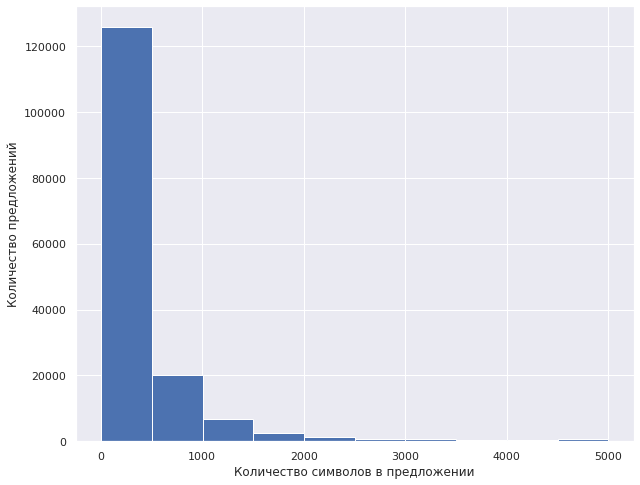

In [11]:
plt.figure(figsize=(10, 8))
df.text.apply(lambda x: len(x)).hist();
plt.xlabel('Количество символов в предложении');
plt.ylabel('Количество предложений');

Есть предложения, в которых очень много символов, может быть так, что товар имеет слишком подробное описание, из-за чего и получается так много символов. Плюсом к этому может идти большая длина слов.

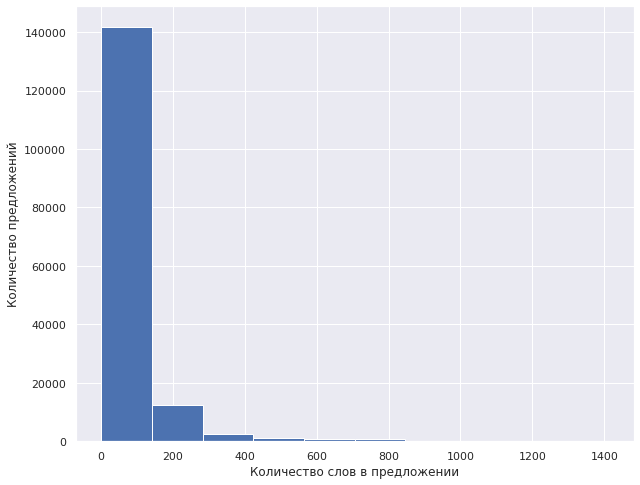

In [12]:
plt.figure(figsize=(10, 8))
df.text.apply(lambda x: len(x.split())).hist();
plt.xlabel('Количество слов в предложении');
plt.ylabel('Количество предложений');

Видно, что в основном в предложении меньше слов, чем 512. 512, т.к. в Bert ограничение, можно загружать предложения с максимум 512 словами в предложении

In [13]:
df.toxic.value_counts()

0    143106
1     16186
Name: toxic, dtype: int64

Имеется большой дисбаланс класса

---

Какое решение задачи я вижу. Собираюсь использовать DistilBert, после чего обучить линейную модель на эмбедингах, леса трогать не собираюсь, т.к. они слишком долго обучаются, да и линейные модели подходят лучше. Также обучу Bert для классификации, а после предобученную модель на классификацию комментариев. Сравню результаты и решу, какая лучше

## DistilBert

Переведу все комменатрии в токены, после чего сделаю эмбединги

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained("distilbert-base-uncased")

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
vector = df['text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=512, truncation=True))
padded = np.array([i + [0]*(512 - len(i)) for i in vector.values])

In [ ]:
attention_mask = np.where(padded != 0, 1, 0)

In [ ]:
padded.shape

(159292, 512)

In [ ]:
batch_size = 30
embeddings = [] 
for i in notebook.tqdm(range((padded.shape[0] // batch_size)+1)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]).cuda()
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)]).cuda()

        with torch.no_grad():
            model.cuda()
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)

        embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy()) 
        del batch
        del attention_mask_batch
        del batch_embeddings

  0%|          | 0/5310 [00:00<?, ?it/s]

In [ ]:
features = np.concatenate(embeddings)
target = df['toxic']

In [ ]:
features.shape

(159292, 768)

Разделю получившиеся эмбединги на трейн/тест, после чего отправлю обучаться логистическую регрессию

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

### LogisticRegression

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
lr = LogisticRegression(max_iter=300)
lr.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(max_iter=300)

In [ ]:
pred = lr.predict(X_test)
preds_lr = f1_score(y_test, pred)
preds_lr

0.7363288052943225

Попробуем увеличить результат с помощью нахождения правильного трешхолда

In [ ]:
predict = lr.predict_proba(X_train)[:, 1]
best_thres = 0.01
max_f_score = 0
for i in range(1, 100):
    thres = i / 100
    var = f1_score(y_train, list(map(int, predict >= thres)))
    if var > max_f_score:
        max_f_score = var
        best_thres = thres

In [ ]:
max_f_score, best_thres

(0.7702152873790242, 0.38)

Результат увеличился на хороший процент

<div style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 3px solid indigo; padding: 15px"> 
<h2 align="center"> Вывод <a class="tocSkip"> </h2>
Получил неплохой результат, а с помощью нахождения правильного трешхолда получил результат лучше, чем он был.

---

### Bert для классификации 

Подготовим данные для обучения, для этого нужно использовать специальный класс

In [ ]:
dataset = datasets.load_dataset('csv', data_files='/content/new_df')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-a64b285a29c8d935/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
train, test = dataset['train'].train_test_split(test_size=0.2).values()

In [ ]:
dataset = datasets.DatasetDict({"train": train, "test": test})

In [ ]:
for i in ['train', 'test']:
    dataset[i] = dataset[i].remove_columns(['Unnamed: 0'])

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'toxic'],
        num_rows: 127433
    })
    test: Dataset({
        features: ['text', 'toxic'],
        num_rows: 31859
    })
})

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
def preprocess(label):
    for i in range(len(label['text'])-1):
        label['text'][i] = re.sub('\\n', ' ', label['text'][i]).lower()
    return label

In [ ]:
dataset = dataset.map(preprocess, batched=True)

  0%|          | 0/128 [00:00<?, ?ba/s]

  0%|          | 0/32 [00:00<?, ?ba/s]

In [ ]:
def tokenize_function(label):
    return tokenizer(label["text"], padding='max_length', truncation=True)


tokenized_datasets = dataset.map(tokenize_function, batched=True)

  0%|          | 0/128 [00:00<?, ?ba/s]

  0%|          | 0/32 [00:00<?, ?ba/s]

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
for i in ['train', 'test']:
    tokenized_datasets[i] = tokenized_datasets[i].remove_columns(['text'])

In [ ]:
tokenized_datasets = tokenized_datasets.rename_column("toxic", "labels")

In [ ]:
tokenized_datasets.set_format("torch")

Возьмем маленькие выборки для того, чтобы быстрее обучить модель и получить результаты

In [ ]:
small_train = tokenized_datasets["train"].shuffle(seed=42).select(range(12000))
small_test = tokenized_datasets["test"].shuffle(seed=42).select(range(3000))

In [ ]:
train_dataloader = DataLoader(small_train, shuffle=True, batch_size=8)
test_dataloader = DataLoader(small_test, batch_size=8)

In [ ]:
optimizer = AdamW(model.parameters(), lr=5e-5)

In [ ]:
num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
progress_bar = tqdm(range(num_training_steps))

model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

  0%|          | 0/4500 [00:00<?, ?it/s]

In [ ]:
metric = load_metric("f1")
model.eval()
for batch in test_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])

score = metric.compute()['f1']

In [ ]:
score

0.8170940170940172

Результат лучше, чем у логистической регрессии, обученной на эмбедингах DistilBert

<div style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 3px solid indigo; padding: 15px"> 
<h2 align="center"> Вывод <a class="tocSkip"> </h2>
С помощью обучения Bert Classification смог улучшить результат на 4 процента

---

## Предобученная модель

In [ ]:
features = df['text']
target = df['toxic']
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [ ]:
pipe = pipeline(model='unitary/toxic-bert', device=0)

Downloading:   0%|          | 0.00/811 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/967 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/174 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
pred = pipe(X_test.tolist(), padding=True, max_length=512, batch_size=30, truncation=True)

In [ ]:
pred[:10]

[{'label': 'toxic', 'score': 0.0007824263302609324},
 {'label': 'toxic', 'score': 0.0006994084687903523},
 {'label': 'toxic', 'score': 0.000614841643255204},
 {'label': 'toxic', 'score': 0.0005937712267041206},
 {'label': 'toxic', 'score': 0.0005797310150228441},
 {'label': 'toxic', 'score': 0.8115167617797852},
 {'label': 'toxic', 'score': 0.9887065887451172},
 {'label': 'toxic', 'score': 0.0027503736782819033},
 {'label': 'toxic', 'score': 0.0006308386800810695},
 {'label': 'toxic', 'score': 0.0006385344895534217}]

In [ ]:
preds = [i['score'] for i in pred]

In [ ]:
preds = np.where(np.array(preds) >= 0.5, 1, 0)

In [ ]:
preds_pretrain = f1_score(y_test, preds)
preds_pretrain

0.9414006669842782

Результат почти идеален, предобученная модель показала себя намного лучше, чем остальные

In [ ]:
score_df = pd.DataFrame([max_f_score, preds_pretrain, score], index = ['distillbert', 'pretrain', 'bert classification'], columns=['score'])

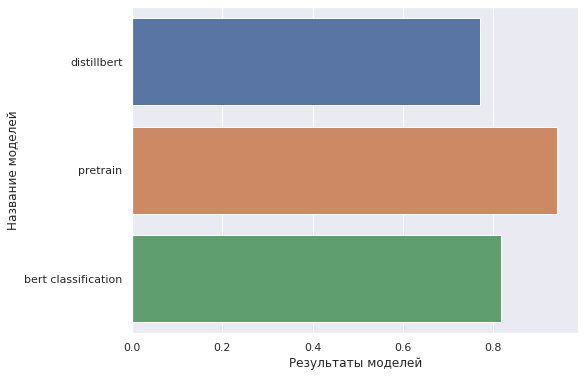

In [ ]:
plt.figure(figsize=(8, 6))
sns.barplot(x=score_df['score'], y=score_df.index);
plt.xlabel('Результаты моделей');
plt.ylabel('Название моделей');


Исходя из графика можно сказать, что лучше всего себя показала уже предобученная модель, результат которой 0.94

<div style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 3px solid indigo; padding: 15px"> 
<h2 align="center"> Вывод <a class="tocSkip"> </h2>
Взяв уже предобученную модель на классификацию отзывов, смог получить f1 score 0.94, что невероятно хорошо. В итоге выбрал предобученную модель как лучшую.

## Выводы

In [ ]:
confusion_matrix(y_test, preds)

array([[28526,   132],
       [  237,  2964]])

Получается так, что в большей степени модель ошибается в случае предсказания положительных отзывов, он считает,что они негативные. А отрицательные отзывы он предсказывает положительными намного меньше. Следовательно, у нас большой precision и recall чуть меньше.

<div style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 3px solid indigo; padding: 15px"> 
<h2 align="center"> Вывод <a class="tocSkip"> </h2>
Проделав работу я понял, что лучше всего использовать предобученные модели, переделав ее под себя, если это нужно, т.к. они имели больше данных для обучения, чем имеются у меня. Использование лесных моделей для обучения на эмбедингах - не лучшая затея, т.к. они дают не самый лучших результат и обучаются невероятно долго. Как итог - выбрал предобученную модель и добился результата f1 score - 0.94